<a href="https://colab.research.google.com/github/YU0211/DL/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch as torch
from torch import nn
from torch.autograd import Variable as V
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import Tensor
from torch import nn
import os
import json
import random
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

### Paramereters

In [ ]:
#----------Hyper Parameters----------#
hidden_size = 512
#The number of vocabulary
vocab_size = 30
teacher_forcing_ratio = 1.0
LR = 0.05
batch_size = 64
output_size = 22
embedding_length = 300
EOS = 29
SOS = 28
pad_index=27
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Functions

In [ ]:
def compute_bleu(output, reference):
    cc = SmoothingFunction()
    if len(reference) == 3:
        weights = (0.33,0.33,0.33)
    else:
        weights = (0.25,0.25,0.25,0.25)
    return sentence_bleu([reference], output,weights=weights,smoothing_function=cc.method1)

In [ ]:
class Index2Char():
    def __init__(self, char_to_index):
        self.index_to_char = {index: char for char, index in char_to_index.items()}

    def __call__(self, indices:list, without_token=True):
        if type(indices) == Tensor:
            indices = indices.tolist()
        result =   ''.join(self.index_to_char.get(index, '') for index in indices)
        if without_token:
            result = result.split('<EOS>')[0]
            result = result.replace('<SOS>', '').replace('<EOS>', '').replace('[pad]', '')
        return result


In [ ]:
def metrics(pred:list, target:list) -> float:
    """
    pred: list of strings
    target: list of strings

    return: accuracy(%)
    """
    if len(pred) != len(target):
        raise ValueError('length of pred and target must be the same')
    correct = 0
    for i in range(len(pred)):
        if pred[i] == target[i]:
            correct += 1
    return correct / len(pred) * 100

In [ ]:
def printplot(setname,losses, accuarcys, bleus):
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 3, 1)
  plt.plot(losses,color='orange')
  plt.xlabel('Epoch')
  plt.ylabel(f'Average {setname} Loss')
  plt.title(f'{setname} Loss Per Epoch')

  plt.subplot(1, 3, 2)
  plt.plot(bleus,color='orange')
  plt.xlabel('Epoch')
  plt.ylabel(f'Average {setname} BLEU Score')
  plt.title(f'{setname} BLEU Score Per Epoch')

  plt.subplot(1, 3, 3)
  plt.plot(accuarcys,color='orange')
  plt.xlabel('Epoch')
  plt.ylabel(f'Average {setname} Accuracy %')
  plt.title(f'{setname} Accuracy(%) Per Epoch')

  plt.show()

In [ ]:



class SpellCorrectionDataset(Dataset):
    def __init__(self, root, split='train', padding=0):
        super(SpellCorrectionDataset, self).__init__()

        self.char_to_index = self.build_char_to_index()
        self.padding = padding
        self.data = self.load_data(root, split)

    def build_char_to_index(self):
        # 创建字符到索引的映射
        characters = 'abcdefghijklmnopqrstuvwxyz'
        char_to_index = {char: i + 1 for i, char in enumerate(characters)}
        char_to_index['<UNK>'] = len(char_to_index) + 1  # 未知字符
        char_to_index['<SOS>'] = len(char_to_index) + 1  # 序列开始
        char_to_index['<EOS>'] = len(char_to_index) + 1  # 序列结束
        return char_to_index

    def load_data(self, root, split):
        # 加载 JSON 数据
        filename = f'{root}/{split}.json'
        with open(filename, 'r') as file:
            data = json.load(file)
        flattened_data = []
        for item in data:
            for inp in item["input"]:
                flattened_data.append((inp, item["target"]))
        return flattened_data

    def tokenize(self, text):
        # 将文本转换为索引
         return [self.char_to_index['<SOS>']] + \
               [self.char_to_index.get(char, self.char_to_index['<UNK>']) for char in text] + \
               [self.char_to_index['<EOS>']]
    def pad_sequence(self, sequence):
        # 填充序列至固定长度
        padded_sequence = sequence[:self.padding]
        padded_sequence += [0] * (self.padding - len(padded_sequence))
        return padded_sequence

    def get_char_to_index(self):
        # 返回已创建的 char_to_index 字典
        return self.char_to_index
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        try:
            item = self.data[index]
            # 單詞分割
            input_ids = self.tokenize(item[0])
            target_ids = self.tokenize(item[1])
            input_ids = self.pad_sequence(input_ids)
            target_ids = self.pad_sequence(target_ids)


        except KeyError as e:
            print(f"KeyError accessing data: {e}")
            print(f"Data at index {index} is: {self.data[index]}")
            raise e
        except Exception as e:
            print(f"An error occurred at index {index}: {e}")
            raise e
        return torch.tensor(input_ids, dtype=torch.long), torch.tensor(target_ids, dtype=torch.long)

## Dataset

### Split Dataset

In [ ]:
# i2c = index2char('./data/')

trainset = SpellCorrectionDataset('./data', split='train', padding=22)
trainloader = DataLoader(trainset, batch_size, shuffle=True)
testset = SpellCorrectionDataset('./data', split='test', padding=22)
testloader = DataLoader(testset, batch_size, shuffle=False)
valset = SpellCorrectionDataset('./data', split='new_test', padding=22)
valloader = DataLoader(valset, batch_size, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
char_to_index = trainset.build_char_to_index()

ce_loss = nn.CrossEntropyLoss(ignore_index=0)
print("Train set : ",len(trainset))
print("Test set : ",len(testset))
print("Validation set : ",len(valset))

Train set :  12925
Test set :  50
Validation set :  50


In [ ]:
# for src, tgt in trainloader:
#     print(src.shape)

## Encoder & Decoder

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(embedding_length,hidden_size)
        # self.hidden = self.initHidden()
    def forward(self, input):
        output, hidden = self.lstm(input)
        return output, hidden

    def initHidden(self):
        empty = torch.zeros(1,batch_size, self.hidden_size, device=device)
        return (empty,empty)

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size,num_layers=1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(input_size = output_size, hidden_size = hidden_size,
                            num_layers=num_layers)
        self.out = nn.Linear(hidden_size, vocab_size)
        # self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, input, hidden):
        # output = self.embedding(input).view(1, 1, -1)
        output = F.relu(input)
        output, hidden = self.lstm(output, hidden)
        output = self.out(output[0])
        return output, hidden



## Define Model

In [ ]:
num_inputs = vocab_size
# lstm_layer = nn.LSTM(embedding_length,num_inputs, hidden_size)
#model = d2l.RNNModel(lstm_layer, vocab_size)
class LSTM (nn.Module):
    def __init__(self,vocab_size, embedding_length, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_length)
        self.lstm_encoder = EncoderRNN(num_inputs,hidden_size)
        self.lstm_decoder = DecoderRNN(hidden_size,embedding_length)
        self.i2c = Index2Char(char_to_index)
        self.de_embedding = nn.Embedding(vocab_size, embedding_length)


    def forward(self, input_tensor, tgt_tensor=None, teacher_forcing_ratio=0.5):

        input = self.embedding(input_tensor).to(device)
        tgt = self.embedding(tgt_tensor).to(device)
        tgt = tgt.permute(1, 0, 2)
        input = input.permute(1, 0, 2)

        encoder_output, encoder_hidden = self.lstm_encoder(input)
        decoder_input = input[0,:,:].unsqueeze(0)  # 提取每个序列的第一个词并增加维度
        decoder_hidden = encoder_hidden

        outputs = []
        pre_str = []

        target_length = tgt.size(0)

        for i in range(target_length-1):  # 假设 target_length 已定义
            decoder_output, decoder_hidden = self.lstm_decoder(decoder_input, decoder_hidden)

            character_probs = F.log_softmax(decoder_output, dim=-1)
            pred = character_probs.argmax(dim=-1)
            outputs.append(character_probs)
            decoder_input = self.de_embedding(pred).unsqueeze(0)
            if i == target_length-1:
                break
            if (random.random() < teacher_forcing_ratio) :
                decoder_input = tgt[i+1,:,:].unsqueeze(0)  # Teacher Forcing
        batch_bleu_scores = []

        outputs = torch.stack(outputs, dim=0)
        # print('stack',outputs.shape)
        pred_str_list,tgt_str_list=[],[]
        # print(outputs.size(1))

        total_accuracy = 0
        for i in range(outputs.size(1)):
            indices = outputs[:,i,:].argmax(dim=-1)

            pred_str = self.i2c(indices)
            pred_str_list.append(pred_str)
            reference_indices = tgt_tensor[i, :]
            # print(tgt_tensor.shape)
            # print('pred',pred_str_list)
            reference_str= self.i2c(reference_indices)
            tgt_str_list.append(reference_str)
            # print('tgt',tgt_str_list)
            bleu_score = compute_bleu(pred_str, reference_str)
            batch_bleu_scores.append(bleu_score)
            batch_accuracy = metrics(pred_str_list, tgt_str_list)
            total_accuracy += batch_accuracy
            # print(batch_accuracy)

        avg_bleu = sum(batch_bleu_scores)/len(batch_bleu_scores)
        avg_train_accuracy = total_accuracy / outputs.size(1)
        # avg_batch_acc = batch_accuracy/len
        # print(avg_train_accuracy)
        # print(avg_bleu)
        #
        return outputs,avg_train_accuracy,avg_bleu



In [ ]:
#lstm = nn.LSTM(22,hidden_size,num_layers)

## Train & Test

In [ ]:
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_index)
model = LSTM(vocab_size, embedding_length, hidden_size, output_size)
model = model.to(device)
optimizer = optim.SGD(model.parameters(),lr=1e-1)

def train(model, trainloader, num_epochs=10):
    loss = 0
    avg_losses = []
    bleus = []
    accs = []

    graph_acc=[]
    graph_loss=[]
    graph_bleu=[]
    # model.train()
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for src, tgt in trainloader:
            src, tgt  = src.long().to(device), tgt.long().to(device)
            output,acc, bleu = model(src, tgt)
            # print('output',output.shape,'swap',output.permute(1,2,0).shape)
            output = output.permute(1,2,0)
            # print('tgt',tgt.shape)
            # 正向傳播
            optimizer.zero_grad()
            tgt=tgt[:,1:]
            loss = loss_fn(output, tgt)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            accs.append(acc)
            bleus.append(bleu)

        average_loss = total_loss / len(trainloader)
        avg_losses.append(average_loss)
        avg_acc = sum(accs)/len(accs)
        avg_bleu = sum(bleus)/len(bleus)

        graph_acc.append(avg_acc)
        graph_loss.append(average_loss)
        graph_bleu.append(avg_bleu)
        # print(f'Epoch {epoch+1}/{num_epochs}, Loss: '
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(trainloader)}')




    return graph_acc,graph_loss,graph_bleu

In [ ]:
def eval_model(model, dataloader):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.eval()
    loss = 0
    avg_losses = []
    bleus = []
    accs = []

    graph_acc=[]
    graph_loss=[]
    graph_bleu=[]
    with torch.no_grad():

      total_loss = 0
      for src, tgt in trainloader:
          src, tgt  = src.long().to(device), tgt.long().to(device)
          output,acc, bleu = model(src, tgt)
          output = output.permute(1,2,0)
          tgt=tgt[:,1:]
          loss = loss_fn(output, tgt)

          total_loss += loss.item()
          accs.append(acc)
          bleus.append(bleu)

      average_loss = total_loss / len(trainloader)
      avg_losses.append(average_loss)
      avg_acc = sum(accs)/len(accs)
      avg_bleu = sum(bleus)/len(bleus)

      # graph_acc.append(avg_acc)
      # graph_loss.append(average_loss)
      # graph_bleu.append(avg_bleu)


      return  avg_acc, average_loss, avg_bleu

## Main

In [ ]:
num_epochs = 200
train_acc, train_loss, train_bleu = train(model,trainloader,num_epochs)
val_acc, val_loss, val_bleu = eval_model(model, valloader,num_epochs=1)
test_acc, test_loss, test_bleu = eval_model(model, testloader,num_epochs=1)

printplot('Train',train_loss,train_acc,train_bleu)
printplot('New_Test',val_loss,val_acc,val_bleu)
printplot('Test',test_loss,test_acc,test_bleu)


Epoch 1/200, Loss: 1.3188847940747102
Epoch 2/200, Loss: 1.1818673250698808
Epoch 3/200, Loss: 1.1539117670295262
Epoch 4/200, Loss: 1.139062463056923
Epoch 5/200, Loss: 1.1285890562109429
Epoch 6/200, Loss: 1.1174088359469234
Epoch 7/200, Loss: 1.1042945780376396
Epoch 8/200, Loss: 1.1020809875266386
Epoch 9/200, Loss: 1.0883029548838588
Epoch 10/200, Loss: 1.0950582062844003
Epoch 11/200, Loss: 1.0831471300951325
Epoch 12/200, Loss: 1.071350012380298
Epoch 13/200, Loss: 1.0585137759104815
Epoch 14/200, Loss: 1.0400970020506641
Epoch 15/200, Loss: 1.024640563986089
Epoch 16/200, Loss: 1.0112814304262105
Epoch 17/200, Loss: 1.0030789986105249
Epoch 18/200, Loss: 0.9891748387034577
Epoch 19/200, Loss: 0.9936114711926716
Epoch 20/200, Loss: 0.9844312706206104
Epoch 21/200, Loss: 0.9784224664810861
Epoch 22/200, Loss: 0.9699131501193093
Epoch 23/200, Loss: 0.9541818056956376
Epoch 24/200, Loss: 0.9472768660819176
Epoch 25/200, Loss: 0.9493330542994017
Epoch 26/200, Loss: 0.933218943600607

KeyboardInterrupt: ignored

Train accuarcy:21.315348009884197, Train loss:0.09748707527276312,Train bleu:0.40124065059382513
Test accuracy: 72.44516125211398, Test loss: 0.09261712192161249, Test bleu: 0.831169581194539
Val accuracy: 71.80558592028524, Val loss: 0.09207265399912797, Val bleu: 0.8303610825296268


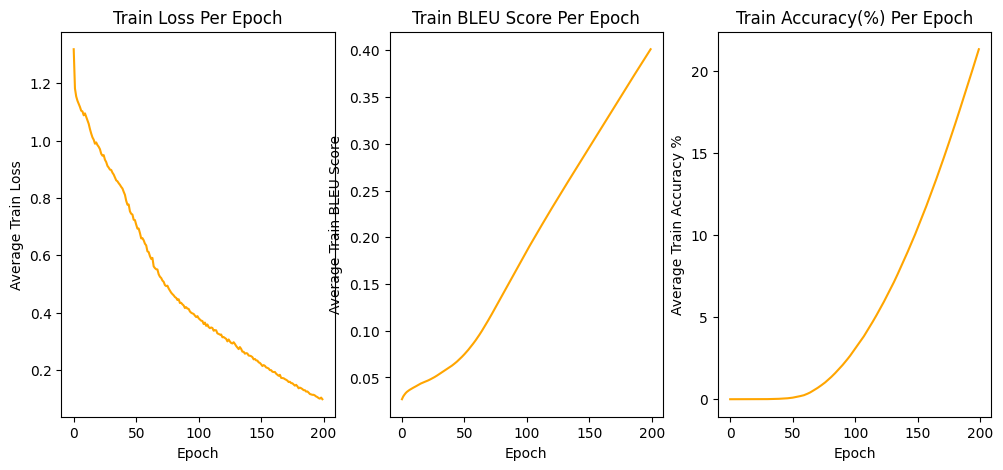

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00023996898967068535, 0.0002249709278162675, 0.0002117373438270753, 0.00019997415805890446, 0.0001894492023715937, 0.0007571459011110903, 0.0007210913343915147, 0.0013615967778361096, 0.0032233449208016233, 0.003450154465773254, 0.003564846265093871, 0.003427736793359491, 0.0034854922022836965, 0.0038645599491632333, 0.004719864344032381, 0.005389833410506565, 0.006671873923620323, 0.007991711787606217, 0.008752971431214202, 0.01078325081786544, 0.013475643547882466, 0.01578408141442156, 0.018107384952592835, 0.021015861051477316, 0.023106108072483974, 0.02527118072187297, 0.029144357045833222, 0.030408340866332838, 0.03402571858426538, 0.037860004845531925, 0.04239365514662974, 0.05081143630271859, 0.05842749894261574, 0.06712980107289272, 0.07563506123123419, 0.08432154280651687, 0.0953184692096634, 0.10998928161834115, 0.12423012400155374, 0.13942175453872033, 0.1543353851824802, 0.17214419529236114, 0.18867294

In [ ]:
val_acc, val_loss, val_bleu = eval_model(model, valloader)
test_acc, test_loss, test_bleu = eval_model(model, testloader)

# printplot('New_Test',val_loss,val_acc,val_bleu)
# printplot('Test',test_loss,test_acc,test_bleu)
print(f'Train accuarcy:{train_acc[-1]}, Train loss:{train_loss[-1]},Train bleu:{train_bleu[-1]}' )
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}, Test bleu: {test_bleu}')
print(f'Val accuracy: {val_acc}, Val loss: {val_loss}, Val bleu: {val_bleu}')
printplot('Train',train_loss,train_acc,train_bleu)
print(train_acc)

In [ ]:
printplot('Train',train_loss,train_acc,train_bleu)
printplot('New_Test',val_loss,val_acc,val_bleu)
printplot('Test',test_loss,test_acc,test_bleu)